In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from scipy.misc import imread
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils

from collections import Counter

import datetime

%matplotlib inline

Using TensorFlow backend.


In [2]:
class_names = ['adult_females', 'adult_males', 'juveniles', 'pups', 'subadult_males']

my_dir = "/Volumes/dax/seals/Kaggle-NOAA-SeaLions/"

In [8]:
blacklist_fin = open(my_dir + 'MismatchedTrainImages.txt')

blacklist_ws = blacklist_fin.readlines()
blacklist = []
for i in blacklist_ws:
    blacklist.append(i.strip() + '.jpg')
    
blacklist.append('train.csv')

#print(blacklist[:5])

In [9]:
file_names = os.listdir(my_dir + "Train/")
file_names = sorted(file_names, key=lambda 
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item)) 

# select a subset of files to run on
# file_names = file_names[0:1]

# dataframe to store results in
coordinates_df = pd.DataFrame(index=file_names, columns=class_names)

#print(file_names[:])

In [10]:
for filename in file_names:
    if filename in blacklist:
        pass
    else:
        # read the Train and Train Dotted images
        image_1 = cv2.imread(my_dir + "/TrainDotted/" + filename)
        image_2 = cv2.imread(my_dir + "/Train/" + filename)

        cut = np.copy(image_2)

        # absolute difference between Train and Train Dotted
        image_3 = cv2.absdiff(image_1,image_2)

    # mask out blackened regions from Train Dotted
        mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        mask_1[mask_1 < 20] = 0
        mask_1[mask_1 > 0] = 255

        mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
        mask_2[mask_2 < 20] = 0
        mask_2[mask_2 > 0] = 255

        image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
        image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 

        # convert to grayscale to be accepted by skimage.feature.blob_log
        image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)

        # detect blobs
        blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)

        adult_males = []
        subadult_males = []
        pups = []
        juveniles = []
        adult_females = [] 

        image_circles = image_1

        for blob in blobs:
            # get the coordinates for each blob
            y, x, s = blob
            # get the color of the pixel from Train Dotted in the center of the blob
            g,b,r = image_1[int(y)][int(x)][:]

            # decision tree to pick the class of the blob by looking at the color in Train Dotted
            if r > 200 and g < 50 and b < 50: # RED
                adult_males.append((int(x),int(y)))
                cv2.circle(image_circles, (int(x),int(y)), 20, (0,0,255), 10) 
            elif r > 200 and g > 200 and b < 50: # MAGENTA
                subadult_males.append((int(x),int(y))) 
                cv2.circle(image_circles, (int(x),int(y)), 20, (250,10,250), 10)
            elif r < 100 and g < 100 and 150 < b < 200: # GREEN
                pups.append((int(x),int(y)))
                cv2.circle(image_circles, (int(x),int(y)), 20, (20,180,35), 10)
            elif r < 100 and  100 < g and b < 100: # BLUE
                juveniles.append((int(x),int(y))) 
                cv2.circle(image_circles, (int(x),int(y)), 20, (180,60,30), 10)
            elif r < 150 and g < 50 and b < 100:  # BROWN
                adult_females.append((int(x),int(y)))
                cv2.circle(image_circles, (int(x),int(y)), 20, (0,42,84), 10)  

            cv2.rectangle(cut, (int(x)-112,int(y)-112),(int(x)+112,int(y)+112), 0,-1)

        coordinates_df["adult_males"][filename] = adult_males
        coordinates_df["subadult_males"][filename] = subadult_males
        coordinates_df["adult_females"][filename] = adult_females
        coordinates_df["juveniles"][filename] = juveniles
        coordinates_df["pups"][filename] = pups

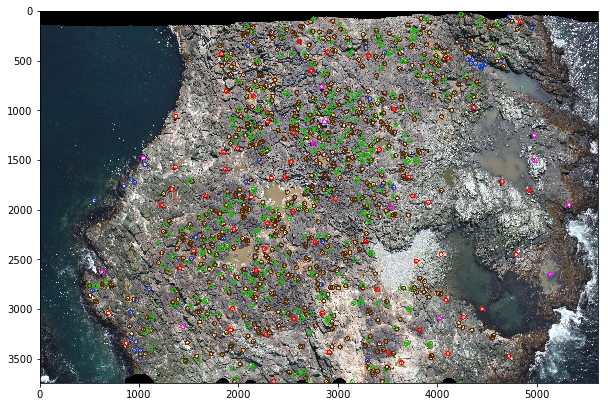

In [11]:
f, ax = plt.subplots(1,1,figsize=(10,16))
ax.imshow(cv2.cvtColor(image_circles, cv2.COLOR_BGR2RGB))
plt.show()

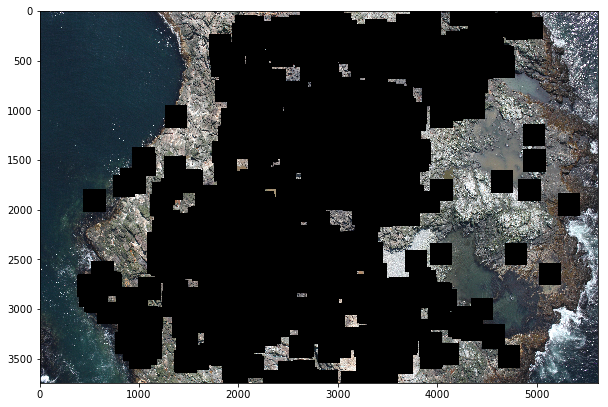

In [12]:
f, ax = plt.subplots(1,1,figsize=(10,16))
ax.imshow(cv2.cvtColor(cut, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
x = []
y = []

for filename in file_names:    
    image = cv2.imread(my_dir + "/Train/" + filename)
    for lion_class in class_names:
        try:
            for coordinates in coordinates_df[lion_class][filename]:
                thumb = image[coordinates[1]-32:coordinates[1]+32,coordinates[0]-32:coordinates[0]+32,:]
                if np.shape(thumb) == (64, 64, 3):
                    x.append(thumb)
                    y.append(lion_class)
        except:
            pass

In [14]:
for i in range(0,np.shape(cut)[0],224):
    for j in range(0,np.shape(cut)[1],224):                
        thumb = cut[i:i+64,j:j+64,:]
        if np.amin(cv2.cvtColor(thumb, cv2.COLOR_BGR2GRAY)) != 0:
            if np.shape(thumb) == (64,64,3):
                x.append(thumb)
                y.append("negative")  

In [15]:
class_names.append("negative")

In [16]:
x = np.array(x)
y = np.array(y)

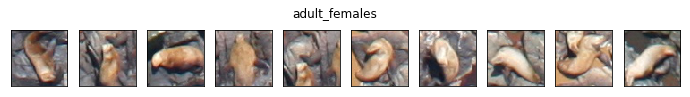

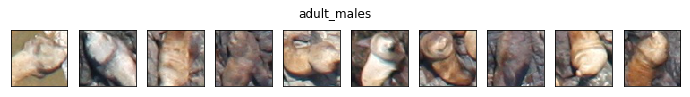

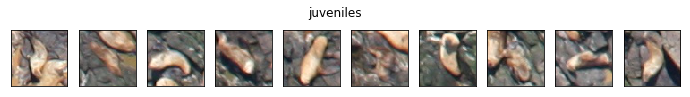

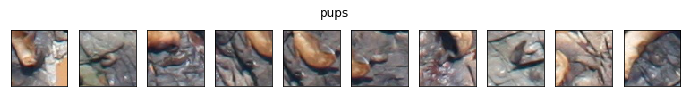

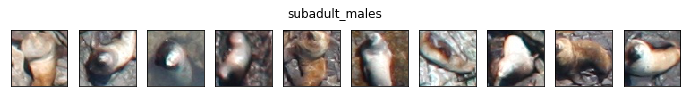

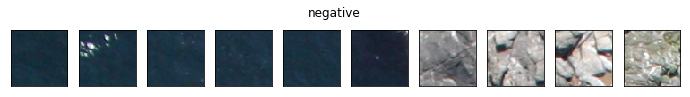

In [17]:
for lion_class in class_names:
    f, ax = plt.subplots(1,10,figsize=(12,1.5))
    f.suptitle(lion_class)
    axes = ax.flatten()
    j = 0
    for a in axes:
        a.set_xticks([])
        a.set_yticks([])
        for i in range(j,len(x)):
            if y[i] == lion_class:
                j = i+1
                a.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
                break

In [18]:
encoder = LabelBinarizer()
encoder.fit(y)
y = encoder.transform(y).astype(float)

In [19]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))


model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
history = model.fit(x, y, epochs=10, verbose=0)

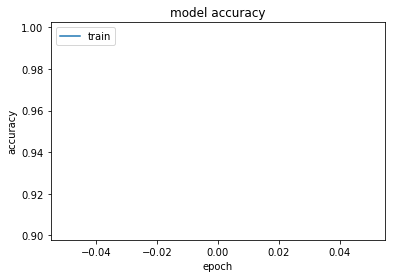

In [22]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
test_file_names = os.listdir(my_dir + "Test/")
test_file_names = sorted(test_file_names, key=lambda 
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item)) 

# select a subset of files to run on
#test_file_names = test_file_names[0:2]

# dataframe to store results in
test_coordinates_df = pd.DataFrame(0, index=test_file_names, columns=class_names)

print(test_file_names[:5])
print(test_coordinates_df)


SyntaxError: can't assign to function call (<ipython-input-55-9d013aacbe10>, line 14)

In [56]:
for filename in test_file_names:
    img = cv2.imread(my_dir + "Test/"  + filename)

    x_test = []

    for i in range(0,np.shape(img)[0],64):
        for j in range(0,np.shape(img)[1],64):                
            thumb = img[i:i+64,j:j+64,:]        
            if np.shape(thumb) == (64,64,3):
                x_test.append(thumb)

    x_test = np.array(x_test)

    y_predicted = model.predict(x_test, verbose=0)

    y_predicted = encoder.inverse_transform(y_predicted)

    the_counter = Counter(y_predicted)
    
    for key in the_counter:
        test_coordinates_df.set_value(index = filename, col = key, value = the_counter[key])
        


In [61]:
protect_df = test_coordinates_df
#print(test_coordinates_df)

#del test_coordinates_df['negative']
test_coordinates_df = test_coordinates_df[['adult_males', 'subadult_males', 'adult_females', 'juveniles', 'pups']]
print(test_coordinates_df)

      adult_males subadult_males adult_females juveniles pups
0.jpg          30              1            35        15   25
1.jpg          87              4            99       141   84


In [73]:
test_coordinates_df.to_csv(my_dir + datetime.date.today().isoformat() + '_submission.csv')